In [1]:
# Importing the libraries
import numpy as np
import sys
import scipy.io as sio  # For reading the matlab .mat format
from scipy.stats import zscore, entropy
from scipy.special import binom as binomial
import collections
import pickle as pk
import itertools
import persim
import matplotlib.pyplot as plt
import iisignature as iis
import gudhi
from gtda.plotting import plot_diagram
#import cechmate as cm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def create_filtration_2(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            sc.insert(simplices, -weight)
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                sc.insert(simplices, -weight)
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
        
    return(sc, list_violating_triangles,hyper_coherence)

In [3]:
def create_diagram_directly_2(mv_time_series, indifferent_value):
    L=lead_matrix_1(time_series)
    T=lead_tensor_1(time_series)
    f=create_filtration_2(L,T,indifferent_value)
    sc=f[0]    
    dgm=sc.persistence()
    return dgm

In [4]:
def lead_matrix_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,2)
    S=sig[N:].reshape(N,N)
    L=(S-S.T)/2
    return L

In [5]:
def lead_tensor_1(mv_time_series):
    N=mv_time_series.shape[1]
    sig=iis.sig(mv_time_series,3)
    l=N+N*N
    S=sig[l:].reshape(N,N,N)
    T=(S-S.transpose((0,2,1))+S.transpose((2,0,1))-S.transpose((2,1,0))+S.transpose((1,2,0))-S.transpose((1,0,2)))/6
    return T

In [6]:
def fix_violations(list_simplices):
     # Sorting the simplices in a descending order according to weights
    sorted_simplices = sorted(list_simplices, key=lambda x: x[1], reverse=True)

        # Remove the violations
    list_violating_triangles = []
    list_simplices_for_filtration = []
    set_simplices = set()
    counter = 0
    triangles_count = 0
    violation_triangles = 0
    violation_triangles_negativeterms = 0

        # Loop over the sorted simplices, and flippling the sign of all the weights (so that the points in the persistence diagram are above the diagonal)
    for index, i in enumerate(sorted_simplices):
        simplices, weight = i

            # If the current simplex is an edge or a node, then I will immediately include it
        if len(simplices) <= 2:
            list_simplices_for_filtration.append((simplices, -weight))
            set_simplices.add(tuple(simplices))
            counter += 1
        else:
        # If the current simplex is a triplet, I check whether all the sub-simplices have been included.
            flag = 0
            n0=simplices[0]
            n1=simplices[1]        
            n2=simplices[2]
            if (n0,n1) in set_simplices:
                flag=flag+1
            if (n1,n2) in set_simplices:
                flag=flag+1
            if (n0,n2) in set_simplices:
                flag=flag+1

                # If all the sub-simplices already belong to the set, then I add it in the filtration
            if flag == 3:
                set_simplices.add(tuple(simplices))
                list_simplices_for_filtration.append((simplices, -weight))
                counter += 1
                triangles_count += 1
            else:
                violation_triangles += 1
                list_violating_triangles.append((simplices, np.abs(weight), 3 - flag))

# Fraction of positive triangle discarderd (a.k.a. the hyper coherence)
    hyper_coherence = (1.0 * violation_triangles) /(triangles_count + violation_triangles)
    return(list_simplices_for_filtration, list_violating_triangles, hyper_coherence)



In [7]:
def create_filtration(Lead_matrix, Lead_tensor,indifferent_value):
    

    # Creating the list of simplicial complex with all the edges and triangles
    sc=gudhi.SimplexTree()
    list_simplices = []
    N=Lead_matrix.shape[0]
    for i in range(N):
        for j in range(N):
            if np.abs(Lead_matrix[i,j])<indifferent_value:
                Lead_matrix[i,j]=0
            for k in range(N):
                if np.abs(Lead_tensor[i,j,k])<indifferent_value:
                    Lead_tensor[i,j,k]=0

        

        # Selecting the extremal weight between edges and triplets. It will be assigned to all the nodes (i.e. nodes enter at the same instant)
    m_weight = np.max([np.ceil(np.max(np.abs(Lead_matrix))), np.ceil(np.max(np.abs(Lead_tensor)))])
    # Adding all the nodes from the beginning with the same weights
    for i in range(N):
        list_simplices.append(([i], m_weight))

        # Adding the edges:
        # Also, modify the signs of the weights to correct the z-score so that: if the edge signal is fully coherent, then assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            if (not i==j):
                weight=np.abs(Lead_matrix[i,j])
                list_simplices.append(([i,j], weight))

        # Adding the triplets
        # Here I modify the signs of the weights, if it is fully coherent I assign a positive sign, otherwise negative
    for i in range(N):
        for j in range(i,N):
            for k in range(j,N):
                if ((not (i==j)) and (not(j==k)) and (not(i==k))):
                    weight=np.abs(Lead_tensor[i,j,k])
                    list_simplices.append(([i,j,k], weight))

    list_simplices_for_filtration, list_violations, percentage_of_triangles_discarded = fix_violations(list_simplices)
        
    return(list_simplices_for_filtration, list_violations, percentage_of_triangles_discarded)

In [8]:
def create_diagram_directly(mv_time_series, indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration(L,T,indifferent_value)
    simpl_list=f[0]
    sc=gudhi.SimplexTree()
    for i in enumerate(simpl_list):
        index,simplices=i
        sc.insert(simplices[0], filtration=simplices[1])
        
    dgm=sc.persistence()
    return dgm
    

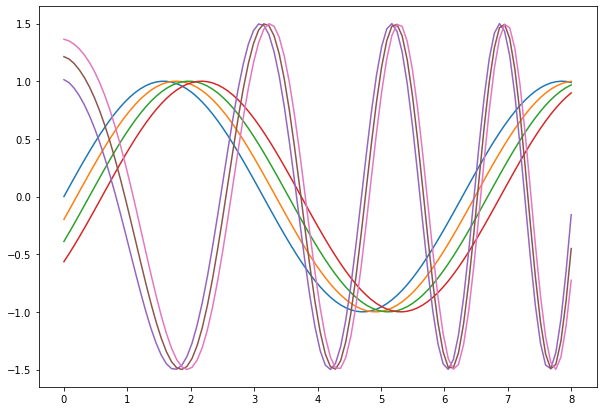

In [9]:
# SIMPLE EXPERIMENT, NO NOISE


time_series=np.zeros((100,7))
t=np.linspace(0,8,100)
time_series[:,0]=np.sin(t)
time_series[:,1]=np.sin(t-0.2)
time_series[:,2]=np.sin(t-0.4)
time_series[:,3]=np.sin(t-0.6)

time_series[:,4]=1.5*np.sin(pow(t,1.5)+2.4)
time_series[:,5]=1.5*np.sin(pow(t,1.5)+2.2)
time_series[:,6]=1.5*np.sin(pow(t,1.5)+2)


plt.figure(figsize=(10,7))
for i in range(7):
    plt.plot(t,time_series[:,i])
plt.show()


usetex mode requires TeX.


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

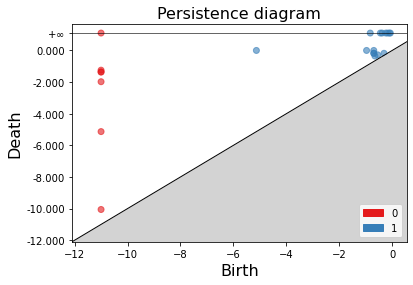

In [10]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

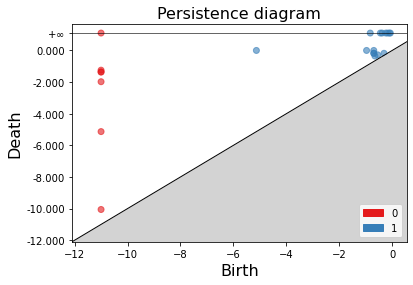

In [11]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

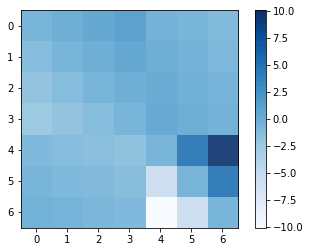

In [12]:
L=lead_matrix_1(time_series)
plt.imshow(L, alpha=0.9, cmap="Blues")
plt.colorbar()

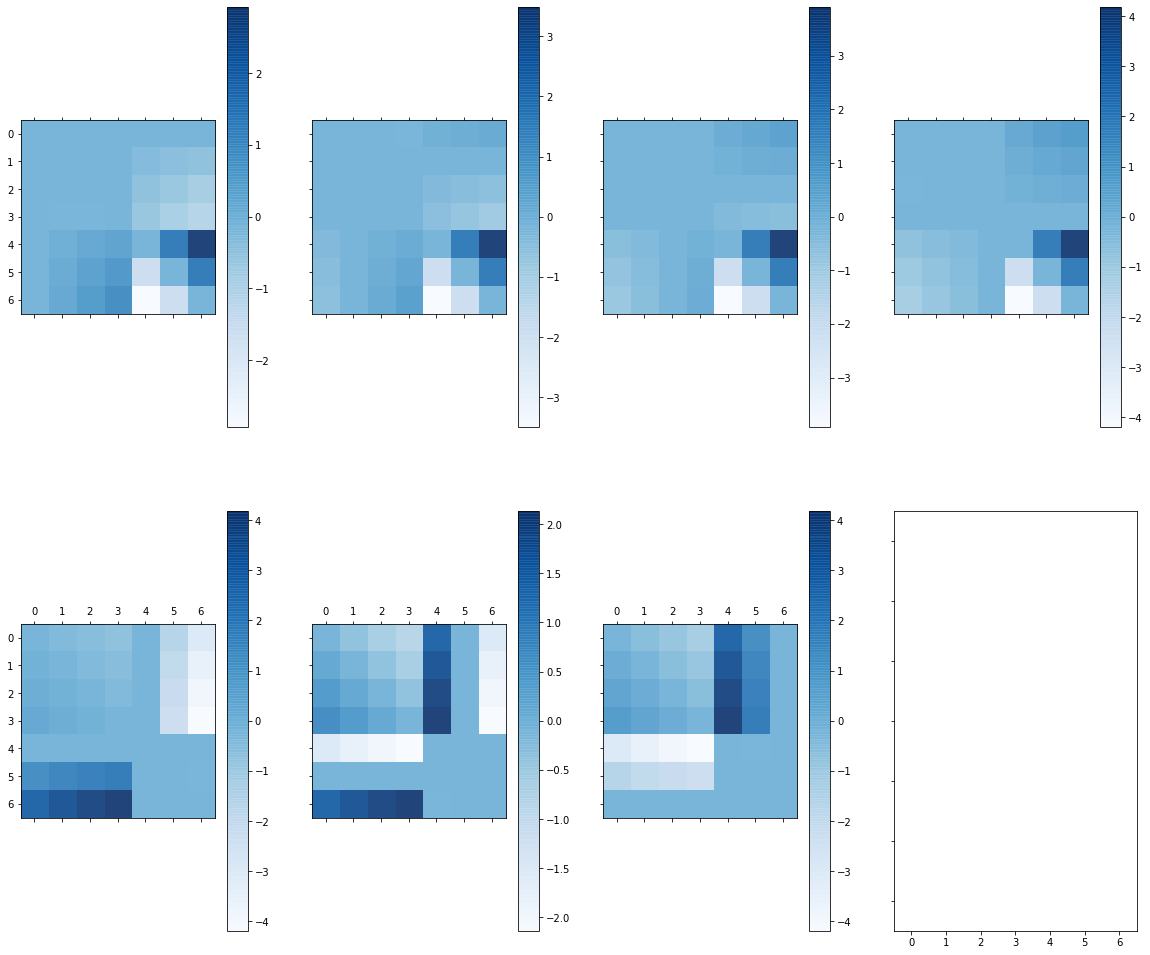

In [13]:
T=lead_tensor_1(time_series)

fig, axs = plt.subplots(2, 4, figsize=(20,17), sharex=True, sharey=True)

for i in range(7):
    
    ax = axs.flatten()
    
    pos=ax[i].matshow(T[i,:,:], alpha=0.9, cmap="Blues")
    pos
    fig.colorbar(pos,ax=ax[i])

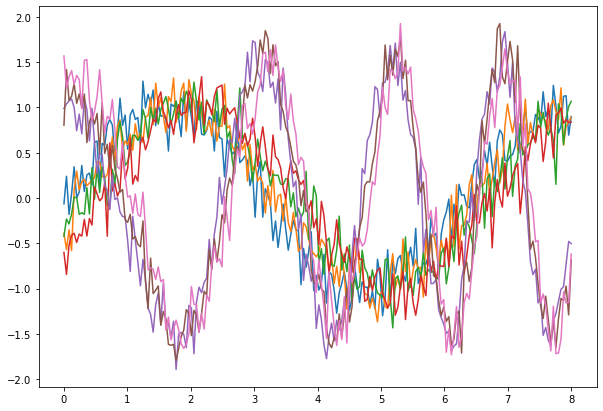

In [14]:
# SIMPLE EXPERIMENT, NOISE


time_series=np.zeros((200,7))

t=np.linspace(0,8,200)

noise=np.random.normal(0,0.2,200)
time_series[:,0]=np.sin(t)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,1]=np.sin(t-0.2)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,2]=np.sin(t-0.4)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,3]=np.sin(t-0.6)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,4]=1.5*np.sin(pow(t,1.5)+2.4)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,5]=1.5*np.sin(pow(t,1.5)+2.2)+noise

noise=np.random.normal(0,0.2,200)
time_series[:,6]=1.5*np.sin(pow(t,1.5)+2)+noise


plt.figure(figsize=(10,7))
for i in range(7):
    plt.plot(t,time_series[:,i])
plt.show()

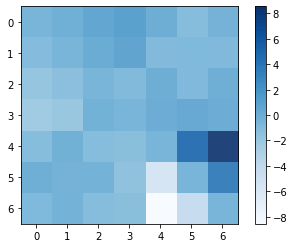

In [15]:
L=lead_matrix_1(time_series)
plt.imshow(L, alpha=0.9, cmap="Blues")
plt.colorbar()

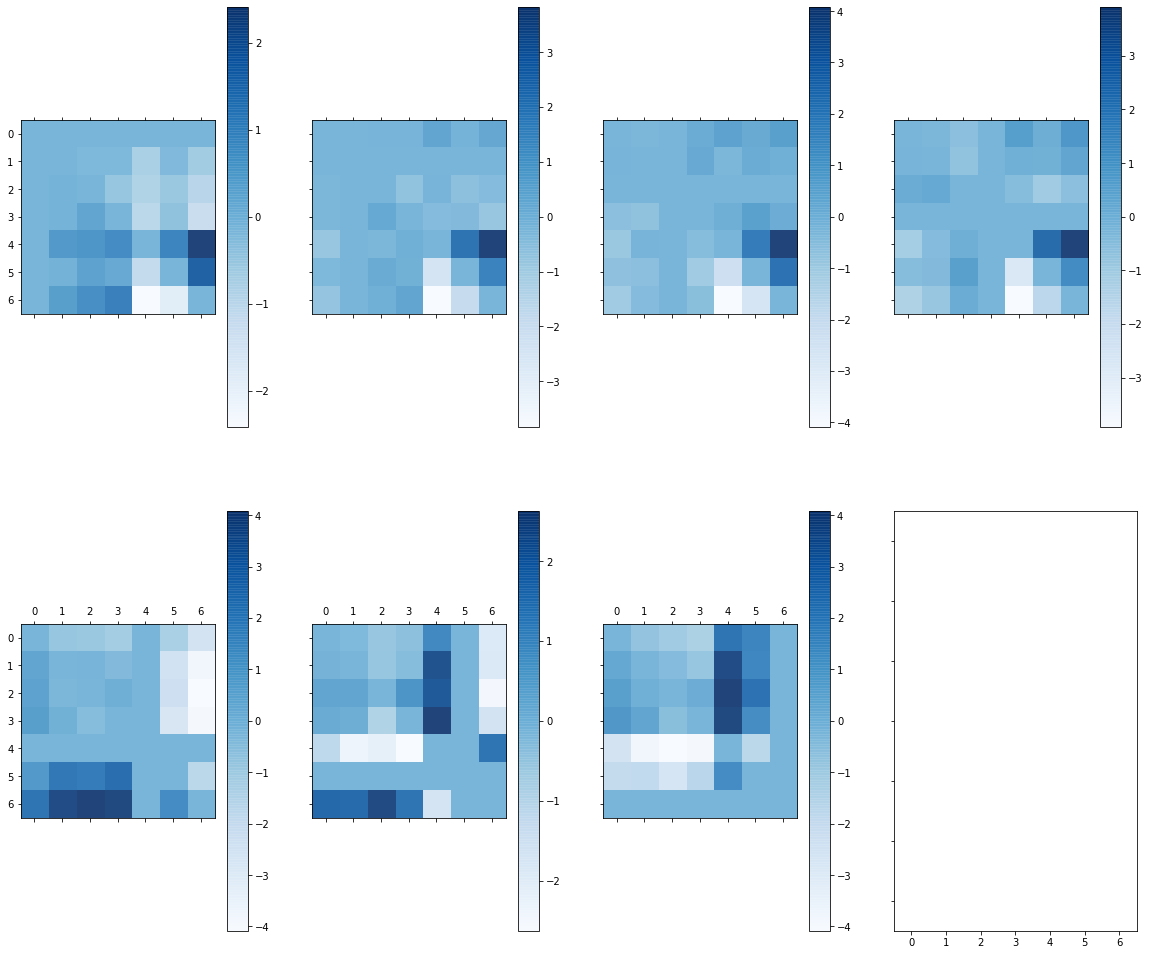

In [16]:
T=lead_tensor_1(time_series)

fig, axs = plt.subplots(2, 4, figsize=(20,17), sharex=True, sharey=True)

for i in range(7):
    
    ax = axs.flatten()
    
    pos=ax[i].matshow(T[i,:,:], alpha=0.9, cmap="Blues")
    pos
    fig.colorbar(pos,ax=ax[i])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

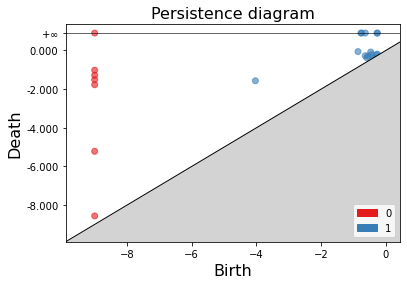

In [17]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

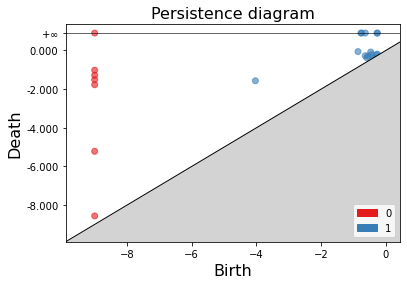

In [18]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

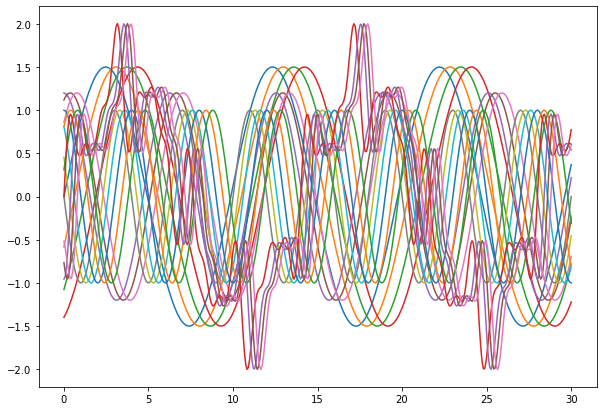

In [19]:
# 4 CLUSTERS NO NOISE

t=np.linspace(0,30,400)





time_series=np.zeros((400,17))



noise=np.random.normal(0,0.2,400)
time_series[:,0]=1.5*np.sin(2*t/np.pi)

noise=np.random.normal(0,0.2,400)
time_series[:,1]=1.5*np.sin(2*t/np.pi-0.4)

noise=np.random.normal(0,0.2,400)
time_series[:,2]=1.5*np.sin(2*t/np.pi-0.8)

noise=np.random.normal(0,0.2,400)
time_series[:,3]=1.5*np.sin(2*t/np.pi-1.2)


noise=np.random.normal(0,0.2,400)
time_series[:,4]=1.2*np.sin(t+1.6)
noise=np.random.normal(0,0.2,400)
time_series[:,5]=1.2*np.sin(t+1.2)

noise=np.random.normal(0,0.2,400)
time_series[:,6]=1.2*np.sin(t+0.8)


noise=np.random.normal(0,0.2,400)
time_series[:,7]=np.sin(np.pi*(t+2)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,8]=np.sin(np.pi*(t+1.7)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,9]=np.sin(np.pi*(t+1.4)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,10]=np.sin(np.pi*(t+1)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,11]=np.sin(np.pi*(t+0.6)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,12]=np.sin(np.pi*(t+0.2)/2)




noise=np.random.normal(0,0.2,400)
time_series[:,13]=4*(np.sin(np.pi*t/7)+np.sin(6*np.pi*t/7)/3+np.sin(10*np.pi*t/7)/5+np.sin(14*np.pi*t/7)/7)/np.pi


noise=np.random.normal(0,0.2,400)
time_series[:,14]=4*(np.sin(np.pi*(t-0.4)/7)+np.sin(6*np.pi*(t-0.4)/7)/3+np.sin(10*np.pi*(t-0.4)/7)/5+np.sin(14*np.pi*(t-0.4)/7)/7)/np.pi

noise=np.random.normal(0,0.2,400)
time_series[:,15]=4*(np.sin(np.pi*(t-0.6)/7)+np.sin(6*np.pi*(t-0.6)/7)/3+np.sin(10*np.pi*(t-0.6)/7)/5+np.sin(14*np.pi*(t-0.6)/7)/7)/np.pi

noise=np.random.normal(0,0.2,400)
time_series[:,16]=4*(np.sin(np.pi*(t-0.8)/7)+np.sin(6*np.pi*(t-0.8)/7)/3+np.sin(10*np.pi*(t-0.8)/7)/5+np.sin(14*np.pi*(t-0.8)/7)/7)/np.pi


plt.figure(figsize=(10,7))
for i in range(17):
    plt.plot(t,time_series[:,i])
plt.show()


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

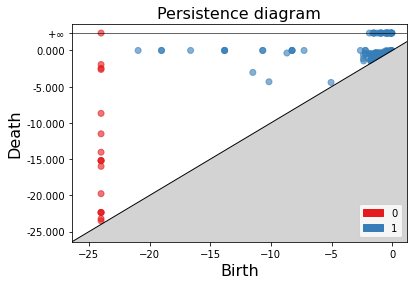

In [20]:
# EXTENSIVE FASHION JUST TO VERIFY THINGS ARE THE SAME

L=lead_matrix_1(time_series)
T=lead_tensor_1(time_series)
f=create_filtration(L,T,0)
simpl_list=f[0]
sc=gudhi.SimplexTree()
for i in enumerate(simpl_list):
    index,simplices=i
    sc.insert(simplices[0], filtration=simplices[1])
        
dgm=sc.persistence()
gudhi.plot_persistence_diagram(dgm)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

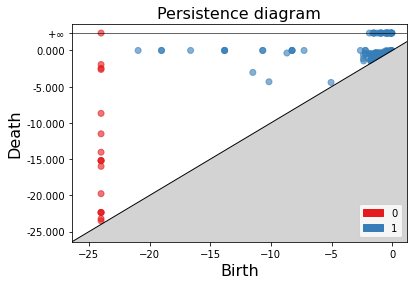

In [21]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

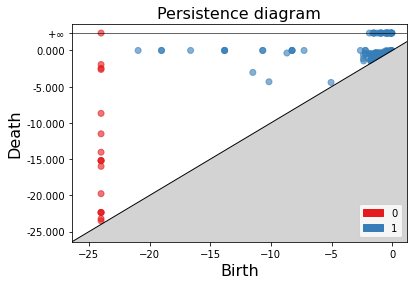

In [22]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

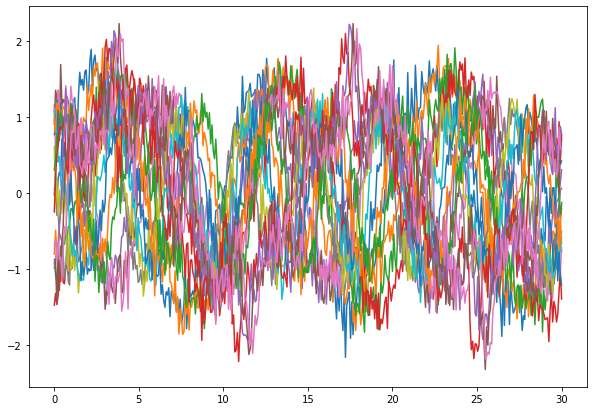

In [23]:
# 4 CLUSTERS with NOISE

t=np.linspace(0,30,400)
time_series=np.zeros((400,17))



noise=np.random.normal(0,0.2,400)
time_series[:,0]=1.5*np.sin(2*t/np.pi)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,1]=1.5*np.sin(2*t/np.pi-0.4)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,2]=1.5*np.sin(2*t/np.pi-0.8)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,3]=1.5*np.sin(2*t/np.pi-1.2)+noise


noise=np.random.normal(0,0.2,400)
time_series[:,4]=1.2*np.sin(t+1.6)+noise
noise=np.random.normal(0,0.2,400)
time_series[:,5]=1.2*np.sin(t+1.2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,6]=1.2*np.sin(t+0.8)+noise


noise=np.random.normal(0,0.2,400)
time_series[:,7]=np.sin(np.pi*(t+2)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,8]=np.sin(np.pi*(t+1.7)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,9]=np.sin(np.pi*(t+1.4)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,10]=np.sin(np.pi*(t+1)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,11]=np.sin(np.pi*(t+0.6)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,12]=np.sin(np.pi*(t+0.2)/2)+noise




noise=np.random.normal(0,0.2,400)
time_series[:,13]=4*(np.sin(np.pi*t/7)+np.sin(6*np.pi*t/7)/3+np.sin(10*np.pi*t/7)/5+np.sin(14*np.pi*t/7)/7)/np.pi+noise


noise=np.random.normal(0,0.2,400)
time_series[:,14]=4*(np.sin(np.pi*(t-0.4)/7)+np.sin(6*np.pi*(t-0.4)/7)/3+np.sin(10*np.pi*(t-0.4)/7)/5+np.sin(14*np.pi*(t-0.4)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.2,400)
time_series[:,15]=4*(np.sin(np.pi*(t-0.6)/7)+np.sin(6*np.pi*(t-0.6)/7)/3+np.sin(10*np.pi*(t-0.6)/7)/5+np.sin(14*np.pi*(t-0.6)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.2,400)
time_series[:,16]=4*(np.sin(np.pi*(t-0.8)/7)+np.sin(6*np.pi*(t-0.8)/7)/3+np.sin(10*np.pi*(t-0.8)/7)/5+np.sin(14*np.pi*(t-0.8)/7)/7)/np.pi+noise


plt.figure(figsize=(10,7))
for i in range(17):
    plt.plot(t,time_series[:,i])
plt.show()


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

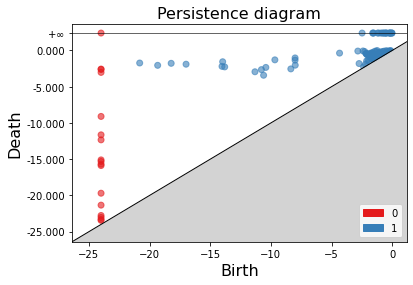

In [24]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

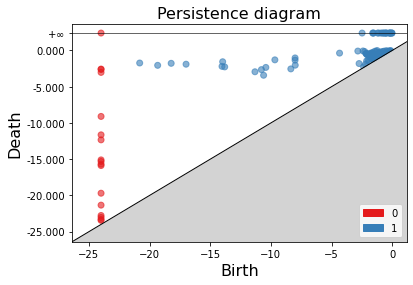

In [25]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

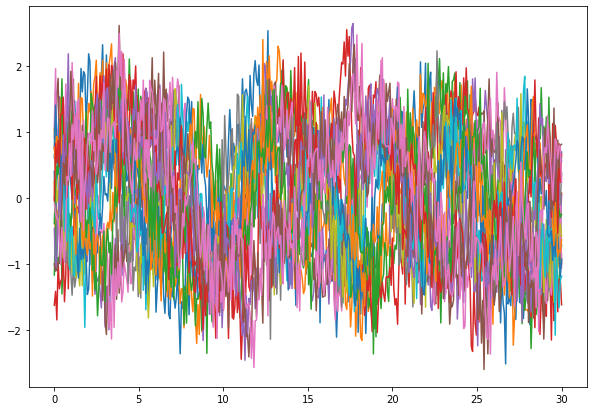

In [26]:
# 4 CLUSTERS WITH MORE NOISE

t=np.linspace(0,30,400)
time_series=np.zeros((400,17))



noise=np.random.normal(0,0.4,400)
time_series[:,0]=1.5*np.sin(2*t/np.pi)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,1]=1.5*np.sin(2*t/np.pi-0.4)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,2]=1.5*np.sin(2*t/np.pi-0.8)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,3]=1.5*np.sin(2*t/np.pi-1.2)+noise


noise=np.random.normal(0,0.4,400)
time_series[:,4]=1.2*np.sin(t+1.6)+noise
noise=np.random.normal(0,0.4,400)
time_series[:,5]=1.2*np.sin(t+1.2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,6]=1.2*np.sin(t+0.8)+noise


noise=np.random.normal(0,0.4,400)
time_series[:,7]=np.sin(np.pi*(t+2)/2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,8]=np.sin(np.pi*(t+1.7)/2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,9]=np.sin(np.pi*(t+1.4)/2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,10]=np.sin(np.pi*(t+1)/2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,11]=np.sin(np.pi*(t+0.6)/2)+noise

noise=np.random.normal(0,0.4,400)
time_series[:,12]=np.sin(np.pi*(t+0.2)/2)+noise




noise=np.random.normal(0,0.4,400)
time_series[:,13]=4*(np.sin(np.pi*t/7)+np.sin(6*np.pi*t/7)/3+np.sin(10*np.pi*t/7)/5+np.sin(14*np.pi*t/7)/7)/np.pi+noise


noise=np.random.normal(0,0.4,400)
time_series[:,14]=4*(np.sin(np.pi*(t-0.4)/7)+np.sin(6*np.pi*(t-0.4)/7)/3+np.sin(10*np.pi*(t-0.4)/7)/5+np.sin(14*np.pi*(t-0.4)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.4,400)
time_series[:,15]=4*(np.sin(np.pi*(t-0.6)/7)+np.sin(6*np.pi*(t-0.6)/7)/3+np.sin(10*np.pi*(t-0.6)/7)/5+np.sin(14*np.pi*(t-0.6)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.4,400)
time_series[:,16]=4*(np.sin(np.pi*(t-0.8)/7)+np.sin(6*np.pi*(t-0.8)/7)/3+np.sin(10*np.pi*(t-0.8)/7)/5+np.sin(14*np.pi*(t-0.8)/7)/7)/np.pi+noise


plt.figure(figsize=(10,7))
for i in range(17):
    plt.plot(t,time_series[:,i])
plt.show()


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

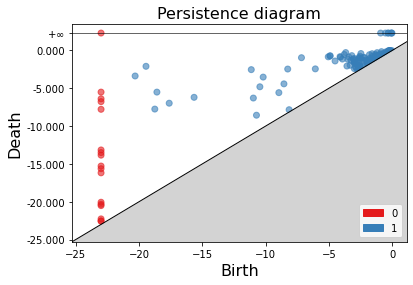

In [27]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

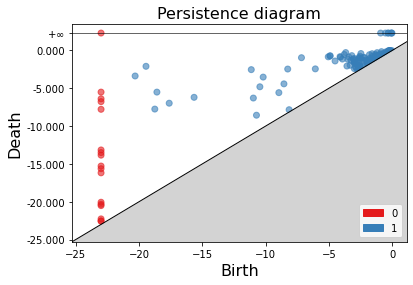

In [28]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

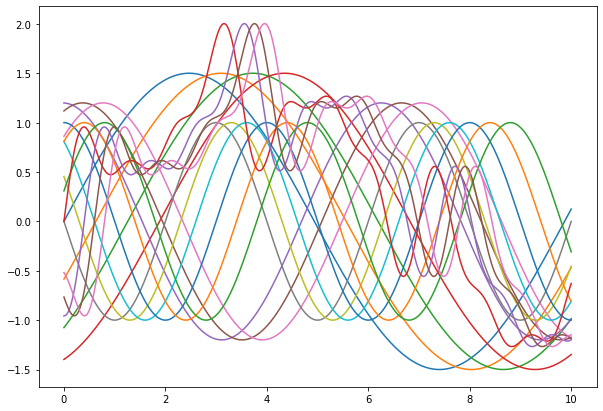

In [29]:
# RESTRICTING TIME WINDOW SIZE
# 4 CLUSTERS with NOISE

t=np.linspace(0,10,400)
time_series=np.zeros((400,17))



noise=np.random.normal(0,0.2,400)
time_series[:,0]=1.5*np.sin(2*t/np.pi)

noise=np.random.normal(0,0.2,400)
time_series[:,1]=1.5*np.sin(2*t/np.pi-0.4)

noise=np.random.normal(0,0.2,400)
time_series[:,2]=1.5*np.sin(2*t/np.pi-0.8)

noise=np.random.normal(0,0.2,400)
time_series[:,3]=1.5*np.sin(2*t/np.pi-1.2)

noise=np.random.normal(0,0.2,400)
time_series[:,4]=1.2*np.sin(t+1.6)
noise=np.random.normal(0,0.2,400)
time_series[:,5]=1.2*np.sin(t+1.2)

noise=np.random.normal(0,0.2,400)
time_series[:,6]=1.2*np.sin(t+0.8)


noise=np.random.normal(0,0.2,400)
time_series[:,7]=np.sin(np.pi*(t+2)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,8]=np.sin(np.pi*(t+1.7)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,9]=np.sin(np.pi*(t+1.4)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,10]=np.sin(np.pi*(t+1)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,11]=np.sin(np.pi*(t+0.6)/2)

noise=np.random.normal(0,0.2,400)
time_series[:,12]=np.sin(np.pi*(t+0.2)/2)




noise=np.random.normal(0,0.2,400)
time_series[:,13]=4*(np.sin(np.pi*t/7)+np.sin(6*np.pi*t/7)/3+np.sin(10*np.pi*t/7)/5+np.sin(14*np.pi*t/7)/7)/np.pi


noise=np.random.normal(0,0.2,400)
time_series[:,14]=4*(np.sin(np.pi*(t-0.4)/7)+np.sin(6*np.pi*(t-0.4)/7)/3+np.sin(10*np.pi*(t-0.4)/7)/5+np.sin(14*np.pi*(t-0.4)/7)/7)/np.pi

noise=np.random.normal(0,0.2,400)
time_series[:,15]=4*(np.sin(np.pi*(t-0.6)/7)+np.sin(6*np.pi*(t-0.6)/7)/3+np.sin(10*np.pi*(t-0.6)/7)/5+np.sin(14*np.pi*(t-0.6)/7)/7)/np.pi

noise=np.random.normal(0,0.2,400)
time_series[:,16]=4*(np.sin(np.pi*(t-0.8)/7)+np.sin(6*np.pi*(t-0.8)/7)/3+np.sin(10*np.pi*(t-0.8)/7)/5+np.sin(14*np.pi*(t-0.8)/7)/7)/np.pi


plt.figure(figsize=(10,7))
for i in range(17):
    plt.plot(t,time_series[:,i])
plt.show()


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

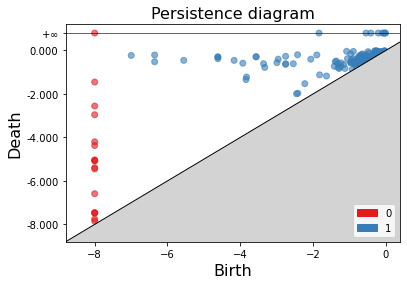

In [30]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

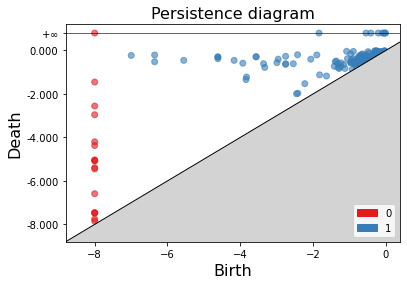

In [31]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

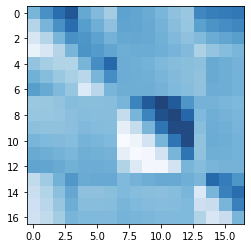

In [32]:
L=lead_matrix_1(time_series)
plt.imshow(L,alpha=0.9,cmap="Blues")

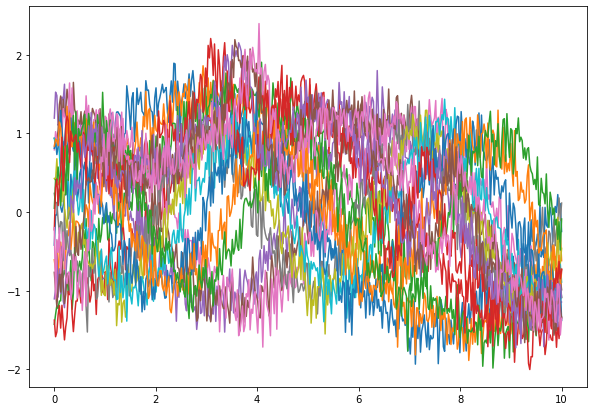

In [33]:
# RESTRICTING TIME WINDOW SIZE
# 4 CLUSTERS with NOISE

t=np.linspace(0,10,400)
time_series=np.zeros((400,17))



noise=np.random.normal(0,0.2,400)
time_series[:,0]=1.5*np.sin(2*t/np.pi)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,1]=1.5*np.sin(2*t/np.pi-0.4)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,2]=1.5*np.sin(2*t/np.pi-0.8)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,3]=1.5*np.sin(2*t/np.pi-1.2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,4]=1.2*np.sin(t+1.6)+noise
noise=np.random.normal(0,0.2,400)
time_series[:,5]=1.2*np.sin(t+1.2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,6]=1.2*np.sin(t+0.8)+noise


noise=np.random.normal(0,0.2,400)
time_series[:,7]=np.sin(np.pi*(t+2)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,8]=np.sin(np.pi*(t+1.7)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,9]=np.sin(np.pi*(t+1.4)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,10]=np.sin(np.pi*(t+1)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,11]=np.sin(np.pi*(t+0.6)/2)+noise

noise=np.random.normal(0,0.2,400)
time_series[:,12]=np.sin(np.pi*(t+0.2)/2)+noise




noise=np.random.normal(0,0.2,400)
time_series[:,13]=4*(np.sin(np.pi*t/7)+np.sin(6*np.pi*t/7)/3+np.sin(10*np.pi*t/7)/5+np.sin(14*np.pi*t/7)/7)/np.pi+noise


noise=np.random.normal(0,0.2,400)
time_series[:,14]=4*(np.sin(np.pi*(t-0.4)/7)+np.sin(6*np.pi*(t-0.4)/7)/3+np.sin(10*np.pi*(t-0.4)/7)/5+np.sin(14*np.pi*(t-0.4)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.2,400)
time_series[:,15]=4*(np.sin(np.pi*(t-0.6)/7)+np.sin(6*np.pi*(t-0.6)/7)/3+np.sin(10*np.pi*(t-0.6)/7)/5+np.sin(14*np.pi*(t-0.6)/7)/7)/np.pi+noise

noise=np.random.normal(0,0.2,400)
time_series[:,16]=4*(np.sin(np.pi*(t-0.8)/7)+np.sin(6*np.pi*(t-0.8)/7)/3+np.sin(10*np.pi*(t-0.8)/7)/5+np.sin(14*np.pi*(t-0.8)/7)/7)/np.pi+noise


plt.figure(figsize=(10,7))
for i in range(17):
    plt.plot(t,time_series[:,i])
plt.show()


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

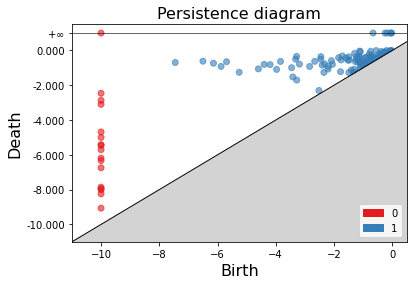

In [34]:
diagram=create_diagram_directly(time_series,0)
gudhi.plot_persistence_diagram(diagram)

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

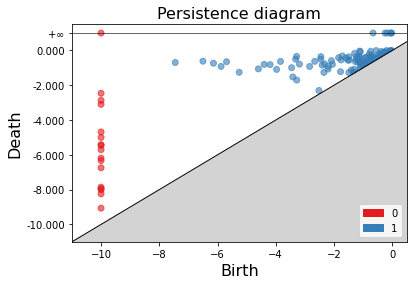

In [35]:
diagram=create_diagram_directly_2(time_series,0)
gudhi.plot_persistence_diagram(diagram)

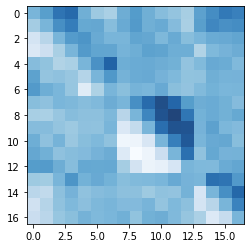

In [36]:
L=lead_matrix_1(time_series)
plt.imshow(L,alpha=0.9,cmap="Blues")